In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sn
from sklearn.datasets import fetch_openml
from sklearn.utils.extmath import softmax
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [2]:
def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

In [3]:
def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])
        
    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

# Logistic Regression

In [4]:
# read csv data
heart = pd.read_csv("heart.csv")
print(heart.head())

   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1  


In [5]:
# separate X and y
X = np.array(heart.iloc[:,:-1])
print(X.shape)
y = np.array(heart.iloc[:,13])
print(y.shape)

(303, 13)
(303,)


In [6]:
# prevent overflow warning
X[:,np.r_[0,3,4,7]] = X[:,np.r_[0,3,4,7]]/100

# onehot2list categorical variables
X = np.delete(X, [2,6,10,11,12], 1)
#X = np.delete(X, [11], 1)
rcg = list2onehot(heart.iloc[:,6].tolist(), [0,1,2])
cp = list2onehot(heart.iloc[:,2].tolist(), [0,1,2,3])
slp = list2onehot(heart.iloc[:,10].tolist(), [0,1,2])
caa = list2onehot(heart.iloc[:,11].tolist(), [0,1,2,3,4])
thall = list2onehot(heart.iloc[:,12].tolist(), [0,1,2,3])

X = np.hstack((X, rcg, cp, slp, caa, thall))
#X = np.hstack((X, cp, slp, thall))
print(X.shape)

(303, 27)


In [7]:
y0 = list2onehot(y.tolist(), [0,1])

In [8]:
# Split the dataset into train and test sets

X_train = []
X_test = []
y_test = []
y_train = []

for i in np.arange(X.shape[0]):
    # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
    U = np.random.rand() # Uniform([0,1]) variable
    if U<0.8:
        X_train.append(X[i,:])
        y_train.append(y0[i])
    else:
        X_test.append(X[i,:])
        y_test.append(y0[i])
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)

X_train.shape (233, 27)
X_test.shape (70, 27)
y_train.shape (233, 2)
y_test.shape (70, 2)


In [9]:
# sigmoid and logit function 
def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

In [10]:
def fit_MLR_GD(Y, H, W0=None, sub_iter=100, stopping_diff=0.01):
        '''
        Convex optimization algorithm for Multiclass Logistic Regression using Gradient Descent 
        Y = (n x k), H = (p x n) (\Phi in lecture note), W = (p x k)
        Multiclass Logistic Regression: Y ~ vector of discrete RVs with PMF = sigmoid(H.T @ W)
        MLE -->
        Find \hat{W} = argmin_W ( sum_j ( log(1+exp(H_j.T @ W) ) - Y.T @ H.T @ W ) )
        '''
        k = Y.shape[1] # number of classes 
        if W0 is None:
            W0 = 2*np.random.rand(H.shape[0],k)-1 #If initial coefficients W0 is None, randomly initialize  
            
        W1 = W0.copy()
        i = 0
        grad = np.ones(W0.shape)
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y
            # grad = H @ (Q - Y).T + alpha * np.ones(W0.shape[1])
            grad = H @ (Q - Y)
            W1 = W1 - (np.log(i+1) / (((i + 1) ** (0.5)))) * grad
            i = i + 1
            # print('iter %i, grad_norm %f' %(i, np.linalg.norm(grad)))
        return W1

In [11]:
def multiclass_accuracy_metrics(Y_test, P_pred, class_labels=None, use_opt_threshold=False):
    # y_test = multiclass one-hot encoding  labels 
    # Q = predicted probability for y_test
    # compuate various classification accuracy metrics
    results_dict = {}
    y_test = []
    y_pred = []
    for i in np.arange(Y_test.shape[0]):
        for j in np.arange(Y_test.shape[1]):
            if Y_test[i,j] == 1:
                y_test.append(j)
            if P_pred[i,j] == np.max(P_pred[i,:]):
                # print('!!!', np.where(P_pred[i,:]==np.max(P_pred[i,:])))
                y_pred.append(j)
            
    confusion_mx = metrics.confusion_matrix(y_test, y_pred)
    print('!!! confusion_mx', confusion_mx)
    results_dict.update({'confusion_mx':confusion_mx})
    
    return results_dict

!!! confusion_mx [[32  2]
 [18 18]]


<ipython-input-10-263749036d71>:17: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y


<AxesSubplot:>

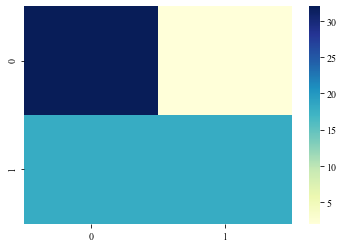

In [12]:
# Train the multiclass logistic regression model 
H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))  # add first row of 1's for bias features 
W = fit_MLR_GD(Y=y_train, H=H_train) 

# Get predicted probabilities 
H_test = np.vstack((np.ones(X_test.shape[0]), X_test.T))
Q = softmax(H_test.T @ W.copy()) # predicted probabilities for y_test # Uses sklearn's softmax for numerical stability

results_dict = multiclass_accuracy_metrics(Y_test=y_test, P_pred=Q)
confusion_mx = results_dict.get('confusion_mx')

sn.heatmap(confusion_mx, cmap="YlGnBu")

In [13]:
def fit_LR_GD(Y, H, W0=None, sub_iter=100, stopping_diff=0.01):
        '''
        Convex optimization algorithm for Logistic Regression using Gradient Descent 
        Y = (n x 1), H = (p x n) (\Phi in lecture note), W = (p x 1)
        Logistic Regression: Y ~ Bernoulli(Q), Q = sigmoid(H.T @ W)
        MLE -->
        Find \hat{W} = argmin_W ( sum_j ( log(1+exp(H_j.T @ W) ) - Y.T @ H.T @ W ) )
        '''
        if W0 is None:
            W0 = np.random.rand(H.shape[0],1) #If initial coefficients W0 is None, randomly initialize  
            
        
        
        W1 = W0.copy()
        i = 0
        grad = np.ones(W0.shape)
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y
            # grad = H @ (Q - Y).T + alpha * np.ones(W0.shape[1])
            grad = H @ (Q - Y)
            W1 = W1 - (np.log(i+1) / (((i + 1) ** (0.5)))) * grad
            i = i + 1
            # print('iter %i, grad_norm %f' %(i, np.linalg.norm(grad)))
        return W1

In [14]:
def compute_accuracy_metrics(Y_test, P_pred, use_opt_threshold=False):
    # y_test = binary label 
    # Q = predicted probability for y_test
    # compuate various binary classification accuracy metrics
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
    mythre = thresholds[np.argmax(tpr - fpr)]
    myauc = metrics.auc(fpr, tpr)
    # print('!!! auc', myauc)
    
    # Compute classification statistics
    threshold = 0.5
    if use_opt_threshold:
        threshold = mythre
    
    Y_pred = Q.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp)
    specificity = tp / (tp + fn)
    precision = tp / (tp + fp)
    fall_out = fp / (fp + tn)
    miss_rate = fn / (fn + tp)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    results_dict.update({'Fall_out': fall_out})
    results_dict.update({'Miss_rate': miss_rate})
    return results_dict

In [15]:
# Split the dataset into train and test sets

X_train = []
X_test = []
y_test = []
y_train = []

for i in np.arange(X.shape[0]):
    # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
    U = np.random.rand() # Uniform([0,1]) variable
    if U<0.8:
        X_train.append(X[i,:])
        y_train.append(y[i])
    else:
        X_test.append(X[i,:])
        y_test.append(y[i])

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train).reshape(-1,1)
y_test = np.asarray(y_test).reshape(-1,1)

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)
#print('y_test', y_test)

X_train.shape (237, 27)
X_test.shape (66, 27)
y_train.shape (237, 1)
y_test.shape (66, 1)


In [16]:
# fit logistic regression using GD and compute binary classification accuracies

# Train the logistic regression model 
H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))  # add first row of 1's for bias features 
W = fit_LR_GD(Y=y_train, H=H_train)

# Get predicted probabilities 
H_test = np.vstack((np.ones(X_test.shape[0]), X_test.T))
Q = 1 / (1 + np.exp(-H_test.T @ W)) # predicted probabilities for y_test

# Compute binary classification accuracies
results_dict = compute_accuracy_metrics(Y_test=y_test, P_pred = Q)

# Print out the results 

keys_list = [i for i in results_dict.keys()]
for key in keys_list:
    if key not in ['Y_test', 'Y_pred']:
        print('%s = %f' % (key, results_dict.get(key)))


AUC = 0.905331
Opt_threshold = 0.000000
Accuracy = 0.818182
Sensitivity = 0.937500
Specificity = 0.705882
Precision = 0.923077
Fall_out = 0.062500
Miss_rate = 0.294118


<ipython-input-13-7ee600204434>:18: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y


# Naive Bayes

In [17]:
heart = pd.read_csv("heart.csv")
print(heart.head())

   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1  


In [18]:
#preventing overflow errors
large_cols = ["age", "trtbps", "chol", "thalachh"]
for cols in large_cols:
    heart[cols]/= 100
print(heart.head())

    age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0  0.63    1   3    1.45  2.33    1        0      1.50     0      2.3    0   
1  0.37    1   2    1.30  2.50    0        1      1.87     0      3.5    0   
2  0.41    0   1    1.30  2.04    0        0      1.72     0      1.4    2   
3  0.56    1   1    1.20  2.36    0        1      1.78     0      0.8    2   
4  0.57    0   0    1.20  3.54    0        1      1.63     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1  


In [19]:
# separate X and y
X = heart.drop("output", axis =1)
print(X.shape)
y = np.array(heart.iloc[:,13])
print(y.shape)

(303, 13)
(303,)


In [20]:
def create_feature_vectors(df, classifiers):
    feature_vect_list = []
    for i in range(df.shape[0]):
        feature_vect = []
        for col in df.columns:
            value = df.loc[i][col]
            if col not in classifiers.keys():
                feature_vect.append(value)
            else:
                for possible_value in classifiers[col]:
                    if value == possible_value:
                        feature_vect.append(1)
                    else:
                        feature_vect.append(0)
        #print(len(feature_vect))
        feature_vect_list.append(feature_vect)
    feature_vect_list = np.asarray(feature_vect_list)
    return feature_vect_list

In [21]:
def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

In [22]:
#define classifiers
classifiers = {"cp": [], "slp": [], "thall": [], "restecg": [], "caa": []}
#assigns classifiers with all the possible classifications
for col in heart.columns:
    if col in classifiers.keys():
        for value in heart[col]:
            if value not in classifiers[col]:
                classifiers[col].append(value)
        classifiers[col].sort()

X = create_feature_vectors(X, classifiers)

In [23]:
y0 = list2onehot(y.tolist(), [0,1])
print(y0.shape)

(303, 2)


In [24]:
def fit_MNB(Y, H):
    '''
    Fit Multinomial Naive Bayes Calssifier
    Use the Maximum Likelihood prior and class conditional probabilities (in closed forms)
    Y = (n x k), H = (p x n) (\Phi in lecture note), W = (p x k)
    prior on class labels = empirical PMF = [ # class i examples / total ]
    class-conditional for class i = [ # word j in class i examples / # words in class i examples]
    Output = prior (k, ), class_conditional_PMF = (k, p)
    '''
    k = Y.shape[1] # number of classes 

    prior = np.sum(Y, axis=0)/np.sum(np.sum(Y, axis=0))

    class_conditional_PMF = []
    for i in np.arange(Y.shape[1]):
        idx = np.where(Y[:,i]==1)
        sub_H = H[:,idx[0]] + 1# add psuedocount
        word_count_per_class = np.sum(sub_H, axis=1)
        class_conditional_PMF.append(word_count_per_class/np.sum(word_count_per_class))

    return prior, np.asarray(class_conditional_PMF)

In [25]:
def predict_MNB(X_test, prior, class_conditional_PMF):
    '''
    Compute predicted PMF for the test data given prior and class_conditional_PMF
    Simple use of Bayes' Theorem 
    X_test = (p x n) (words x docs)
    '''
    print(X_test.shape)
    print(class_conditional_PMF.shape)
    
    P = class_conditional_PMF / np.min(class_conditional_PMF) # normalize so that log(P) is not too small 
    Q = np.exp(X_test @ np.log(P).T)
    Q = Q * np.repeat(prior[:, np.newaxis], repeats=Q.shape[0], axis=1).T
    sum_of_rows = Q.sum(axis=1)
    
    
    return Q / sum_of_rows[:, np.newaxis]


In [26]:
def multiclass_accuracy_metrics(Y_test, P_pred, class_labels=None, use_opt_threshold=False):
    # y_test = multiclass one-hot encoding  labels 
    # Q = predicted probability for y_test
    # compuate various classification accuracy metrics
    results_dict = {}
    y_test = []
    y_pred = []
    for i in np.arange(Y_test.shape[0]):
        for j in np.arange(Y_test.shape[1]):
            if Y_test[i,j] == 1:
                y_test.append(j)
            if P_pred[i,j] == np.max(P_pred[i,:]):
                # print('!!!', np.where(P_pred[i,:]==np.max(P_pred[i,:])))
                y_pred.append(j)
                
    print("y_test", len(y_test))
    print("y_pred", len(y_pred))
    
    confusion_mx = metrics.confusion_matrix(y_test, y_pred)
    print('!!! confusion_mx', confusion_mx)
    results_dict.update({'confusion_mx':confusion_mx})
    
    return results_dict

In [27]:
def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])
        
    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [28]:
def compute_accuracy_metrics(Y_test, P_pred, use_opt_threshold=False):
    # y_test = binary label 
    # Q = predicted probability for y_test
    # compuate various binary classification accuracy metrics
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
    mythre = thresholds[np.argmax(tpr - fpr)]
    myauc = metrics.auc(fpr, tpr)
    # print('!!! auc', myauc)
    
    # Compute classification statistics
    threshold = 0.5
    if use_opt_threshold:
        threshold = mythre
    
    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp)
    specificity = tp / (tp + fn)
    precision = tp / (tp + fp)
    fall_out = fp / (fp + tn)
    miss_rate = fn / (fn + tp)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    results_dict.update({'Fall_out': fall_out})
    results_dict.update({'Miss_rate': miss_rate})
    return results_dict

In [29]:
# Split the dataset into train and test sets

X_train = []
X_test = []
y_test = []
y_train = []

for i in np.arange(X.shape[0]):
    # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
    U = np.random.rand() # Uniform([0,1]) variable
    if U<0.8:
        X_train.append(X[i,:])
        y_train.append(y0[i])
    else:
        X_test.append(X[i,:])
        y_test.append(y0[i])
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)

X_train.shape (235, 27)
X_test.shape (68, 27)
y_train.shape (235, 2)
y_test.shape (68, 2)


(68, 27)
(2, 27)
y_test 68
y_pred 68
!!! confusion_mx [[32  8]
 [ 2 26]]

AUC = 0.919643
Opt_threshold = 0.549380
Accuracy = 0.852941
Sensitivity = 0.800000
Specificity = 0.928571
Precision = 0.764706
Fall_out = 0.200000
Miss_rate = 0.071429


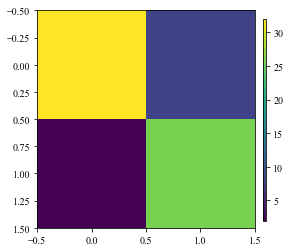

In [30]:
prior, class_cond_PMF = fit_MNB(Y = y_train, H=X_train.T)

predict_test = predict_MNB(X_test, prior, class_cond_PMF)


# Compute binary classification accuracies
results_dict1 = multiclass_accuracy_metrics(Y_test=y_test, P_pred = predict_test)


y_test2 = np.asarray(onehot2list(y_test))
results_dict2 = compute_accuracy_metrics(Y_test = y_test2, P_pred = predict_test[:,1])


# Print out the results 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4,4])

confusion_mx = results_dict1.get("confusion_mx")
im =ax.imshow(confusion_mx)

cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

print()

keys_list = [i for i in results_dict2.keys()]
for key in keys_list:
    if key not in ['Y_test', 'Y_pred']:
        print('%s = %f' % (key, results_dict2.get(key)))

# Feed Forward Neural Network

In [31]:
def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

In [32]:
def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])
        
    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [33]:
# read csv data
heart = pd.read_csv("heart.csv")
print(heart)

     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
2     41    0   1     130   204    0        0       172     0      1.4    2   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
298   57    0   0     140   241    0        1       123     1      0.2    1   
299   45    1   3     110   264    0        1       132     0      1.2    1   
300   68    1   0     144   193    1        1       141     0      3.4    1   
301   57    1   0     130   131    0        1       115     1      1.2    1   
302   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thall  output  
0      0      1       1  

In [34]:
# separate X and y
X = np.array(heart.iloc[:,:-1])
print(X.shape)
y = np.array(heart.iloc[:,13])
print(y.shape)

(303, 13)
(303,)


In [35]:
# prevent overflow warning
X[:,np.r_[0,3,4,7]] = X[:,np.r_[0,3,4,7]]/100

# onehot2list categorical variables
X = np.delete(X, [2,10,11,12],1)
cp = list2onehot(heart.iloc[:,2].tolist(), [0,1,2,3]) 
slp = list2onehot(heart.iloc[:,10].tolist(), [0,1,2]) #what is this
caa = list2onehot(heart.iloc[:,11].tolist(), [0,1,2,3]) #should this be one hot?
thall = list2onehot(heart.iloc[:,12].tolist(), [0,1,2,3]) #what is this
restecg = list2onehot(heart.iloc[:,6].tolist(), [0,1,2]) #what is this

X = np.hstack((X, cp, slp, thall, restecg, caa))
print(X.shape)

(303, 27)


In [36]:
y0 = list2onehot(y.tolist(), [0,1])

In [37]:
# Split the dataset into train and test sets

X_train = []
X_test = []
y_test = []
y_train = []

for i in np.arange(X.shape[0]):
    # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
    U = np.random.rand() # Uniform([0,1]) variable
    if U<0.8:
        X_train.append(X[i,:])
        y_train.append(y[i])
    else:
        X_test.append(X[i,:])
        y_test.append(y[i])

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train).reshape(-1,1)
y_test = np.asarray(y_test).reshape(-1,1)

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)

X_train.shape (242, 27)
X_test.shape (61, 27)
y_train.shape (242, 1)
y_test.shape (61, 1)


In [38]:

import random
import numpy as np

class DeepFFNN(object):
    """
    Author: Hanbaek Lyu
    Genearal Deep Feedforward Neural Network implementation 
    Input data type: training_data = [pattern1, pattern2, ..., pattern n]
    Activation: tanh for hidden layer and sigmoid for output layer 
    
    pattern i = [np.array (input), np.array (output)]
    
    TODO: Currently uses square loss. Should be easy to implement other loss functions. 
    """
    def __init__(self, 
                 hidden_layer_sizes,  # input and output layer sizes read off from training data
                 training_data,  # list of patterns [np.array (input), np.array (output)]
                 activation_list=None): # desired list of activation functions in each layer. 
       
        # initialize training data and layer info
        self.training_data = training_data
        self.activation_list = activation_list
        self.list_layer_sizes = [len(self.training_data[0][0]) + 1] + hidden_layer_sizes + [len(self.training_data[0][1])]        
        # add hidden unit in the input layer. No hidden units for the hidden layers. 
        self.n_layers = len(self.list_layer_sizes)-1
        
        self.initialize()
        
    def initialize(self):
        
        # list of activation functions
        if self.activation_list is None:
            activation_list = ['tanh' for i in np.arange(len(self.list_layer_sizes))]
            activation_list[0] = 'identity'  # dummy activation for the input layer
            activation_list[-1] = 'sigmoid'
            self.activation_list = activation_list
        # default activation of nodes
        node_states = []
        for i in np.arange(len(self.list_layer_sizes)):
            node_states.append(np.zeros(shape=[self.list_layer_sizes[i], ]))
        self.node_states = node_states
        
        # initial weight matrices 
        # use scheme from 'efficient backprop to initialize weights'
        weight_matrices = []
        for i in np.arange(self.n_layers):
            weight_range = 1/(self.list_layer_sizes[i]**(0.5))
            U = np.random.normal(loc = 0, scale = weight_range, size = (self.list_layer_sizes[i], self.list_layer_sizes[i+1]))
            weight_matrices.append(U)
        self.weight_matrices = weight_matrices
           
        # create arrays of 0's to store previous gradients for momentum term in SGD update 
        prev_grad_list = []
        for i in np.arange(self.n_layers):
            V = np.zeros((self.list_layer_sizes[i], self.list_layer_sizes[i+1]))
            prev_grad_list.append(V)
        self.prev_grad_list = prev_grad_list

    def forwardPropagate(self, inputs):
        # Forward propagate the input using the current weights and update node states 
        self.node_states[0][:-1] = inputs # avoid last coordinate for hidden unit 
        for i in np.arange(self.n_layers):    
            X_new = self.node_states[i].T @ self.weight_matrices[i]
            X_new = activation(X_new, type=self.activation_list[i+1])
            self.node_states[i+1] = X_new
        
        return self.node_states[-1]

    def backPropagate(self, targets):
        """
        Backpropagate errors from the output to the input layer 
        Return gradients for the weight matrices
        """
    
        error_list = self.node_states.copy()
        # error at the output layer to be backpropagated 
        error = -(np.asarray(targets) - np.asarray(self.node_states[-1]))
        for L in range(self.n_layers, 0, -1): # layer index to be backpropagated 
            # print('L', L)
            if L < self.n_layers: # Not backpropagating from the output layer
                error = self.weight_matrices[L] @ error_list[L+1].reshape(-1,1)
                error = error[:,0] 
            error_list[L] = delta_activation(self.node_states[L], type=self.activation_list[L]) * error
            
        # Compute the gradients
        grad_list = self.weight_matrices.copy()
        for i in np.arange(self.n_layers):
            grad_list[i] = self.node_states[i].reshape(-1,1) @ error_list[i+1].reshape(1,-1) 
        
        return grad_list


    def train(self, iterations=100, learning_rate=0.5, momentum=0.5, rate_decay=0.01, verbose=True):
        # N: learning rate
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.rate_decay = rate_decay
        error = 10
        i=0
        while (i<iterations) and (error>0.001):
            error = 0.0
            random.shuffle(self.training_data)
            for p in self.training_data:
                inputs = p[0]
                targets = p[1]
                self.forwardPropagate(inputs)
                grad_list = self.backPropagate(targets)
                
                for L in np.arange(self.n_layers):
                    # update the L th weight matrix connecting L th and (L+1)st layers 
                    grad = grad_list[L]
                    prev_grad = self.prev_grad_list[L]
                    self.weight_matrices[L] -= self.learning_rate * grad + self.momentum * prev_grad
                    self.prev_grad_list[L] = grad # store current gradient 
        
                error += (0.5) * np.linalg.norm(np.asarray(targets) - self.node_states[-1])**2
            
            with open('error.txt', 'a') as errorfile:
                errorfile.write(str(error) + '\n')
                errorfile.close()
                
            if (i % 5 == 0) and verbose:
                print('iteration %i, error %-.5f' % (i, error))
            # learning rate decay
            self.learning_rate = 1/(np.log(i+2) * (i+50)**(0.5))
            # self.learning_rate = self.learning_rate * (self.learning_rate / (self.learning_rate + (self.learning_rate * self.rate_decay)))
            
            i += 1  
        
    
    def predict(self, X, normalize = False):
        X = np.asarray(X).T
        x = np.vstack((np.asarray(X), np.ones(X.shape[1]))) # add 1 for hidden units in the input layer
        print('X.shape', X.shape)
    
        for i in np.arange(self.n_layers):    
            x = x.T @ self.weight_matrices[i]
            x = activation(x.T, type=self.activation_list[i+1])
            
        print('y_hat.shape', x.shape)
        return x
    
### Helper functions     
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# derivative of sigmoid
def dsigmoid(y):
    return y * (1.0 - y)

# using tanh over logistic sigmoid is recommended   

def tanh(x):
    return (1-np.exp(-2*x))/(1+np.exp(-2*x))
    # return np.tanh(x)
    
# derivative for tanh sigmoid
def dtanh(y):
    return 1 - y*y


### Helper functions

def loss_function(y, y_hat, type='cross-entropy'):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    if type == 'cross_entropy':
        return cross_entropy(y=y, y_hat=y_hat)
    elif type == 'square':
        return (1/2) * (y_hat - y).T @ (y_hat - y)
    elif type == 'softmax-cross-entropy':
        return cross_entropy(y=y, y_hat=softmax(y_hat))
   

def delta_loss_function(y, y_hat, type='cross-entropy'):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    # return delta_cross_entropy(y=y, y_hat=y_hat/np.sum(y_hat))
    
    if type == 'cross-entropy':
        return delta_cross_entropy(y=y, y_hat=y_hat)
    elif type == 'square':
        return y_hat - y
    elif type == 'softmax-cross-entropy':
        return softmax(y_hat) - y

        
def activation(x, type='sigmoid'):
    if type == 'sigmoid':
        return 1/(1+np.exp(-x))
    elif type == 'ReLU':
        return np.maximum(0,x)
    elif type == 'tanh':
        return tanh(x)
    elif type == 'identity':
        return x
    
def delta_activation(y, type='sigmoid'):
    # derivate of activation function
    if type == 'sigmoid':
        return y*(1-y)
    elif type == 'ReLU':
        return int((y>0))
    elif type == 'tanh':
        return 1-y**2
    elif type == 'identity':
        return 1
        
def sigmoid(x):
    return 1/(1+np.exp(-x))

def ReLU(x):
    return np.maximum(0,x)


def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)

def cross_entropy(y, y_hat):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    return -(y.T @ np.log(y_hat))[0][0]

def delta_cross_entropy(y, y_hat):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    y_hat /= np.max(y_hat)
    z = y.copy()
    for i in np.arange(y.shape[0]):
        a = y.argmax(axis=0)[0]
        z[i,0] = -1/y_hat[a, 0]
    return z

In [39]:
def compute_accuracy_metrics(Y_test, P_pred, use_opt_threshold=False, verbose=True):
    
    # y_test = binary label 
    # P_pred = predicted probability for y_test
    # compuate various binary classification accuracy metrics
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
    mythre = thresholds[np.argmax(tpr - fpr)]
    myauc = metrics.auc(fpr, tpr)
    # print('!!! auc', myauc)
    
    # Compute classification statistics
    threshold = 0.5
    if use_opt_threshold:
        threshold = mythre
    
    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp)
    specificity = tp / (tp + fn)
    precision = tp / (tp + fp)
    fall_out = fp / (fp + tn)
    miss_rate = fn / (fn + tp)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    results_dict.update({'Fall_out': fall_out})
    results_dict.update({'Miss_rate': miss_rate})
    results_dict.update({'Confusion_mx': mcm})
    
    
    if verbose:
        for key in [key for key in results_dict.keys()]:
            if key not in ['Y_test', 'Y_pred', 'Confusion_mx']:
                print('% s ===> %.3f' % (key, results_dict.get(key)))
        print('Confusion matrix \n ===>', mcm)
            
    return results_dict, Y_pred

In [40]:
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

iteration 0, error 43.19119
iteration 5, error 24.04512
iteration 10, error 23.05870
iteration 15, error 22.10144
iteration 20, error 21.69590
iteration 25, error 21.16107
iteration 30, error 20.74605
iteration 35, error 19.98387
iteration 40, error 20.12112
iteration 45, error 19.81058
iteration 50, error 19.20362
iteration 55, error 19.05660
iteration 60, error 18.84456
iteration 65, error 18.42071
iteration 70, error 18.20455
iteration 75, error 17.85300
iteration 80, error 17.60644
iteration 85, error 17.49218
iteration 90, error 17.09805
iteration 95, error 16.67092
X.shape (27, 61)
y_hat.shape (2, 61)
Confusion Matrix: 

AUC ===> 0.927
Opt_threshold ===> 0.681
Accuracy ===> 0.869
Sensitivity ===> 0.731
Specificity ===> 0.971
Precision ===> 0.829
Fall_out ===> 0.269
Miss_rate ===> 0.029
Confusion matrix 
 ===> [[19  7]
 [ 1 34]]


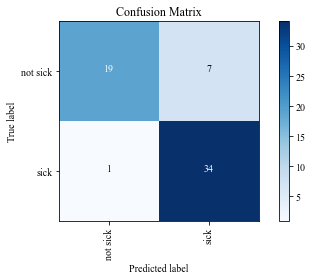

In [41]:
y0 = list2onehot(y_train, [0,1])

out = []
# populate the tuple list with the data
for i in range(X_train.shape[0]):
    item = list((X_train[i,:], y0[i,:])) 
    out.append(item)
    
    

# FFNN training
NN = DeepFFNN(hidden_layer_sizes=[5], training_data = out)
NN.train(iterations=100, learning_rate = 0.5, momentum = 0, rate_decay = 0.01)


# FFNN prediction

X_test /= np.max(X_test)
out_test = []
for i in range(X_test.shape[0]):
    out_test.append(X_test[i,:].tolist())

y_hat = NN.predict(out_test).T

y_test_label = np.asarray(y_test)

P_pred = np.asarray([p[1] for p in y_hat])


print("Confusion Matrix: \n")
metrics, y_preedd = compute_accuracy_metrics(Y_test=y_test, P_pred=P_pred, use_opt_threshold=False, verbose=True)
draw_confusion_matrix(y_test, y_preedd, ['not sick', 'sick'])
